# Projeto de Aprendizagem de Máquina

## *Partitioning fuzzy K-medoids clustering algorithms with relevance weight for each dissimilarity matrix estimated locally*

In [79]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import itertools

from scipy.spatial.distance import pdist, squareform

from sklearn.preprocessing import MinMaxScaler

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.base import clone

from sklearn.neighbors import KernelDensity
from scipy import stats
from scipy.stats import gaussian_kde
from scipy.stats import mannwhitneyu
import scikit_posthocs as sp
from sklearn.base import BaseEstimator, ClassifierMixin



import matplotlib.pyplot as plt
import seaborn as sns

### Leitura dos dados

In [2]:
PATH = '../data/'

In [3]:
view1 = pd.read_csv(os.path.join(PATH, 'mfeat-fac'), sep='\s+', header=None)
view2 = pd.read_csv(os.path.join(PATH, 'mfeat-fou'), sep='\s+',  header=None)
view3 = pd.read_csv(os.path.join(PATH, 'mfeat-kar'), sep='\s+',  header=None)

In [4]:
print(view1.shape)
print(view2.shape)
print(view3.shape)

(2000, 216)
(2000, 76)
(2000, 64)


### Obter target

In [5]:
y = pd.read_csv('../clustering/results_multiviews/particao_crisp.csv', header=None, squeeze=True)

### Pré-processamento

#### Normalização (reescala)

In [6]:
scaler = MinMaxScaler()
view1 = scaler.fit_transform(view1)

scaler = MinMaxScaler()
view2 = scaler.fit_transform(view2)

scaler = MinMaxScaler()
view3 = scaler.fit_transform(view3)

## Classificação

### Valicação cruzada com regra da soma

In [7]:
def fit(model, Xs, y):
    n_datasets = len(Xs)
    estimators = [clone(model) for _ in range(n_datasets)]
    
    for i in range(n_datasets):
        estimators[i].fit(Xs[i], y)
        
    return estimators

In [8]:
def predict(estimators, Xs):
    predictions = []
    
    n_datasets = len(Xs)
    
    for i in range(n_datasets):
        pred = estimators[i].predict_proba(Xs[i])
        predictions.append(pred)
        
    predictions = np.array(predictions)
    
    predictions = np.sum(predictions, axis=0)
    
    predictions = np.argmax(predictions, axis=1)
    
    return predictions

In [9]:
def fine_tuning(model, parameters, Xs_train, y_train, Xs_val, y_val, verbose=0):
    if verbose > 0:
        print('###########')
    
    n_datasets = len(Xs_train)
    
    results = []
    for key, values in parameters.items():
        for value in values:
            clf = model(**{key: value})
    
            estimators = fit(clf, Xs_train, y_train)
            pred = predict(estimators, Xs_val)

            result = accuracy_score(y_val, pred)
            results.append({key: value, 'acurácia': result})

    results_df = pd.DataFrame(results)
    
    best_result = results_df.sort_values('acurácia', ascending=False).iloc[0]
    best_params = best_result[list(parameters.keys())].convert_dtypes().to_dict()
    
    
    if verbose > 0:
        print('Resultados: ')
        print(results_df)
        print('Melhor resultado:')
        print(best_result['acurácia'])
        print('Melhores parâmetros:')
        print(best_params)

    return best_params

In [10]:
def cross_val(model, parameters=None, verbose=0):
    predictions = []
    targets = []
    results = []
    kfold = StratifiedKFold(n_splits=10, shuffle=True)
    for train, test in kfold.split(y.index, y):
        
        best_param = None
        
        if parameters:
            ## Tuning
            
            train_aux, val = train_test_split(train, test_size=0.222)

            y_train = y[train_aux]
            y_val = y[val]

            view1_train = view1[train_aux]
            view2_train = view2[train_aux]
            view3_train = view3[train_aux]

            view1_val = view1[val]
            view2_val = view2[val]
            view3_val = view3[val]

            Xs_train = [view1_train, view2_train, view3_train]
            Xs_val = [view1_val, view2_val, view3_val]
            best_param = fine_tuning(model, parameters, Xs_train, y_train, Xs_val, y_val, verbose)
        
        ## Validation
        y_train = y[train]
        y_test = y[test]

        view1_train = view1[train]
        view2_train = view2[train]
        view3_train = view3[train]

        view1_test = view1[test]
        view2_test = view2[test]
        view3_test = view3[test]
        
        Xs_train = [view1_train, view2_train, view3_train]
        Xs_test = [view1_test, view2_test, view3_test]
        
        if best_param:
            clf = model(**best_param)
        else:
            clf = model()
        
        estimators = fit(clf, Xs_train, y_train)
        pred = predict(estimators, Xs_test)
        
        predictions.extend(pred)
        targets.extend(y_test.values)
        

    results = accuracy_score(targets, predictions)
        
    return results

### Parzen Window

### Implementação da predição com janela de parzen

In [11]:
class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
        
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self
        
    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                             for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

### Experimentos

In [12]:
n_experiments = 30

### Naive Bayes

In [13]:
model = GaussianNB

results_nb = []
for i in tqdm(range(n_experiments)):
    result = cross_val(model)
    results_nb.append(result)
results_nb

100%|██████████| 30/30 [00:06<00:00,  4.39it/s]


[0.7055,
 0.709,
 0.7005,
 0.7035,
 0.707,
 0.7025,
 0.702,
 0.7035,
 0.7,
 0.7035,
 0.706,
 0.706,
 0.7025,
 0.6985,
 0.7025,
 0.703,
 0.705,
 0.7035,
 0.7015,
 0.7045,
 0.702,
 0.703,
 0.7055,
 0.705,
 0.7045,
 0.704,
 0.705,
 0.704,
 0.706,
 0.703]

### k-NN

In [14]:
parameters = {'n_neighbors': [1, 3, 5, 7, 9]}
model = KNeighborsClassifier

results_knn = []
for i in tqdm(range(n_experiments)):
    result = cross_val(model, parameters)
    results_knn.append(result)
results_knn

100%|██████████| 30/30 [15:22<00:00, 30.76s/it]


[0.7555,
 0.7625,
 0.7575,
 0.7575,
 0.758,
 0.758,
 0.7585,
 0.749,
 0.7525,
 0.7555,
 0.765,
 0.7495,
 0.759,
 0.7535,
 0.753,
 0.751,
 0.75,
 0.754,
 0.7555,
 0.753,
 0.7555,
 0.7555,
 0.76,
 0.758,
 0.7535,
 0.761,
 0.7575,
 0.758,
 0.7535,
 0.7485]

### Janela de Parzen

In [15]:
KDEClassifier(**{'bandwidth': 0.1})

KDEClassifier(bandwidth=0.1)

In [16]:
parameters = {'bandwidth': [0.1, 0.3, 0.5, 1, 1.5, 2]}
model = KDEClassifier

results_parzen = []
for i in tqdm(range(n_experiments)):
    result = cross_val(model, parameters)
    results_parzen.append(result)
results_parzen

100%|██████████| 30/30 [30:15<00:00, 60.51s/it]


[0.748,
 0.751,
 0.7445,
 0.744,
 0.7525,
 0.7505,
 0.7435,
 0.749,
 0.7585,
 0.7455,
 0.7425,
 0.748,
 0.74,
 0.748,
 0.749,
 0.742,
 0.742,
 0.7495,
 0.747,
 0.7465,
 0.751,
 0.754,
 0.7495,
 0.747,
 0.7465,
 0.749,
 0.749,
 0.7465,
 0.7485,
 0.7535]

### Box plot

In [17]:
results_df = pd.DataFrame(np.vstack((results_nb, results_knn, results_parzen)).T, columns=['Gaussiano', 'k-NN', 'Parzen'])

In [66]:
results_df = results_df * 100

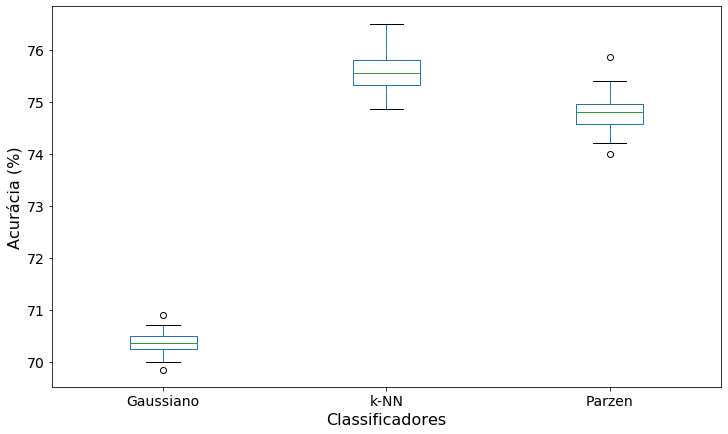

In [76]:
ax = results_df.boxplot(figsize=(12,7), grid=False, fontsize=14)
ax.set_ylabel('Acurácia (%)', fontsize=16)
ax.set_xlabel('Classificadores', fontsize=16)
plt.show()

### Friedman test

In [19]:
stat, p = stats.friedmanchisquare(results_nb, results_knn, results_parzen)

In [20]:
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Distribuições iguais (falha em rejeitar H0)')
else:
    print('Distribuições diferentes (rejeita H0)')

Statistics=55.882, p=0.000
Distribuições diferentes (rejeita H0)


### Intervalo de confiança

In [63]:
def mean_confidence_interval(results, sample_name):
    confidence_level = 0.95
    degrees_freedom = len(results) - 1
    sample_mean = np.mean(results)
    sample_std = np.std(results)
    sample_standard_error = stats.sem(results)

    confidence_interval = stats.t.interval(confidence_level, degrees_freedom, sample_mean, sample_standard_error)

    
    print('### {} ###'.format(sample_name))
    print('Estimativa pontual:', sample_mean)
    print('Desvio padrão:', sample_std)
    print('Intervalo de confiaça:', confidence_interval)
    print('Confiança de {}%'.format(int(confidence_level*100)))
    print('\n')

In [64]:
mean_confidence_interval(results_nb, 'NB')
mean_confidence_interval(results_knn, 'k-NN')
mean_confidence_interval(results_parzen, 'Parzen')

### NB ###
Estimativa pontual: 0.7037333333333333
Desvio padrão: 0.0021241991955139685
Intervalo de confiaça: (0.70292658454921, 0.7045400821174567)
Confiança de 95%


### k-NN ###
Estimativa pontual: 0.7556333333333333
Desvio padrão: 0.003919892288769619
Intervalo de confiaça: (0.7541445989695609, 0.7571220676971057)
Confiança de 95%


### Parzen ###
Estimativa pontual: 0.7478666666666667
Desvio padrão: 0.0039113794099893675
Intervalo de confiaça: (0.7463811654058066, 0.7493521679275268)
Confiança de 95%




In [24]:
mean_confidence_interval(results_nb, 'NB')
mean_confidence_interval(results_knn, 'k-NN')
mean_confidence_interval(results_parzen, 'Parzen')

### NB ###
Estimativa pontual: 0.7037333333333333
Desvio padrão: 0.0021241991955139685
Intervalo de confiaça: (0.70292658454921, 0.7045400821174567)
Confiança de 95%


### k-NN ###
Estimativa pontual: 0.7556333333333333
Desvio padrão: 0.003919892288769619
Intervalo de confiaça: (0.7541445989695609, 0.7571220676971057)
Confiança de 95%


### Parzen ###
Estimativa pontual: 0.7478666666666667
Desvio padrão: 0.0039113794099893675
Intervalo de confiaça: (0.7463811654058066, 0.7493521679275268)
Confiança de 95%




In [30]:
def compare_samples(pair):
    sample_names = pair[0][1] + ' x ' + pair[1][1]
    sample_1 = pair[0][0]
    sample_2 = pair[1][0]
    stat, p = mannwhitneyu(sample_1, sample_2)
    alpha = 0.05
    if p > alpha:
        print(sample_names + ': Distribuições iguais (falha em rejeitar H0). p-value: ' + str(p))
    else:
        print(sample_names + ': Distribuições diferentes (rejeita H0). p-value: '+ str(p))

In [31]:
clf_results = [(results_nb, 'Gaussiano'), (results_knn, 'k-NN'), (results_parzen, 'Parzen')]
for pair in itertools.combinations((clf_results), 2):
    compare_samples(pair)

Gaussiano x k-NN: Distribuições diferentes (rejeita H0). p-value: 1.4458911395362665e-11
Gaussiano x Parzen: Distribuições diferentes (rejeita H0). p-value: 1.4614344017769955e-11
k-NN x Parzen: Distribuições diferentes (rejeita H0). p-value: 1.546666064415921e-08


In [77]:
results = sp.posthoc_nemenyi_friedman(results_df)
results

,Gaussiano,k-NN,Parzen
Gaussiano,1.000,0.001000,0.001000
k-NN,0.001,1.000000,0.003576
Parzen,0.001,0.003576,1.000000


           Gaussiano  k-NN  Parzen
Gaussiano       -1.0   2.0     2.0
k-NN             2.0  -1.0     2.0
Parzen           2.0   2.0    -1.0
-----------


(<matplotlib.axes._subplots.AxesSubplot at 0x7ffa145b6cd0>,
 <matplotlib.colorbar.ColorbarBase at 0x7ffa145764d0>)

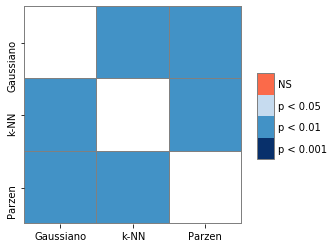

In [78]:
cmap = ['1', '#fb6a4a',  '#08306b',  '#4292c6', '#c6dbef']

heatmap_args = {'cmap': cmap, 'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sp.sign_plot(results, **heatmap_args)